## Systemy zlozone - Politechnika Krakowska 2026, SIiRRz

### Autorzy: Mateusz Wójtowicz SIiRRz2, Jakub Kieliński SIiRRz1

Epidemiologiczne  modele  agentowe.  Symulacja  rozprzestrzeniania  się  epidemii  w 
zależności od cech agentów, struktury społecznej i zaraźliwości choroby. 

=== Importowanie bibliotek ===

In [11]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional

import os

import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from matplotlib import animation
from matplotlib.patches import Patch

=== Glowne parametry modelu ===

In [12]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Populacja i czas
N_AGENTS = 800
T_MAX = 250
N_INIT_INFECTED = 3

# Zaraźliwość wirusa (bazowe p transmisji w pojedynczym losowaniu)
VIRUS_INFECTIVITY = 0.05

# 3-krotne losowanie infekcji
N_INFECTION_TRIALS = 3

# Ozdrowienie (SIR): prawdopodobieństwo przejścia I -> R w kroku czasu
GAMMA = 0.02

# Zróżnicowanie agentów
USE_HETEROGENEITY = True

SUSC_MIN = 0.6
SUSC_MAX = 1.4

RES_TH_MIN = 0.15
RES_TH_MAX = 0.60

# Typy sieci
NETWORK_TYPES = ["ER", "BA", "WS", "SBM"]

# Parametry sieci
ER_P = 0.015
BA_M = 6
WS_K = 10
WS_P_REWIRE = 0.08

SBM_SIZES = [200, 200, 200, 200]  # suma = N_AGENTS
SBM_P_IN = 0.030
SBM_P_OUT = 0.0025

# Wykresy (log)
EPS_LOG = 1e-6
FIG_DPI = 120

# GIF-y
MAKE_GIFS = True
GIF_EVERY = 1
GIF_FPS = 8
GIF_LAYOUT = "spring"
GIF_DIR = "simulation"

os.makedirs(GIF_DIR, exist_ok=True)

=== Budowanie modelu dla roznego typu sieci ===

* ER - Erdősa-Rényiego - model grafu losowego
* BA - Barabásiego-Alberta - model sieci typu "scale-free"
* WS - Wattsa-Strogatza - model sieci typu "small-world"
* SBM - Model stochastycznych blokow - model sluzacy do generowania sieci ze struktura spolecznosci "community structure"

Generowanie sieci kontaktów (ER/BA/WS/SBM)

In [13]:
def build_network(
    network_type: str,
    n_agents: int,
    seed: int = RANDOM_SEED
) -> nx.Graph:
    network_type = network_type.upper()

    if network_type == "ER":
        G = nx.erdos_renyi_graph(n_agents, ER_P, seed=seed)

    elif network_type == "BA":
        # BA wymaga m < n
        m = min(BA_M, max(1, n_agents - 1))
        G = nx.barabasi_albert_graph(n_agents, m, seed=seed)

    elif network_type == "WS":
        # WS wymaga parzystego k i k < n
        k = min(WS_K, n_agents - 1)
        if k % 2 == 1:
            k += 1
        if k >= n_agents:
            k = n_agents - 1 if (n_agents - 1) % 2 == 0 else n_agents - 2
        G = nx.watts_strogatz_graph(n_agents, k, WS_P_REWIRE, seed=seed)

    elif network_type == "SBM":
        if sum(SBM_SIZES) != n_agents:
            raise ValueError(f"SBM_SIZES sum must be {n_agents}, got {sum(SBM_SIZES)}")

        # macierz prawdopodobieństw bloków
        k = len(SBM_SIZES)
        p = np.full((k, k), SBM_P_OUT, dtype=float)
        np.fill_diagonal(p, SBM_P_IN)

        G = nx.stochastic_block_model(SBM_SIZES, p, seed=seed)

        # ujednolicenie etykiet węzłów do 0..N-1
        G = nx.convert_node_labels_to_integers(G)

    else:
        raise ValueError("NETWORK_TYPE must be one of: ER, BA, WS, SBM")

    return G

=== Budowanie modelu Agenta ===

Model agentow i inicjalizacja ich cech

In [14]:
SUSC, INF, REC = 0, 1, 2

@dataclass
class AgentAttributes:
    susceptibility: np.ndarray
    resistance_threshold: np.ndarray


def init_agent_attributes(n: int, use_heterogeneity: bool = True) -> AgentAttributes:
    if not use_heterogeneity:
        return AgentAttributes(
            susceptibility=np.ones(n, dtype=float),
            resistance_threshold=np.full(n, 0.33, dtype=float)
        )

    susceptibility = np.random.uniform(SUSC_MIN, SUSC_MAX, size=n).astype(float)
    resistance_threshold = np.random.uniform(RES_TH_MIN, RES_TH_MAX, size=n).astype(float)

    return AgentAttributes(susceptibility=susceptibility, resistance_threshold=resistance_threshold)


def init_states(n: int, n_init_infected: int) -> np.ndarray:
    states = np.full(n, SUSC, dtype=np.int8)
    idx = np.random.choice(n, size=min(n_init_infected, n), replace=False)
    states[idx] = INF
    
    return states

=== Obliczanie kroku symulacji ===

Rdzen symulacji -> Jedna iteracja SIR na grafie

In [15]:
def sir_step(
    G,
    states: np.ndarray,
    attrs: AgentAttributes,
    virus_infectivity: float,
    n_trials: int,
    gamma: float
) -> tuple[np.ndarray, int]:
    n = states.size
    new_states = states.copy()

    new_infected = np.zeros(n, dtype=bool)

    for v in range(n):
        if states[v] != SUSC:
            continue

        has_infected_neighbor = False
        for u in G.neighbors(v):
            if states[u] == INF:
                has_infected_neighbor = True
                break
        if not has_infected_neighbor:
            continue

        p = virus_infectivity * attrs.susceptibility[v]
        if p < 0.0: p = 0.0
        if p > 1.0: p = 1.0

        successes = 0
        for _ in range(n_trials):
            if np.random.rand() < p:
                successes += 1

        infection_score = successes / float(n_trials)
        if infection_score > attrs.resistance_threshold[v]:
            new_infected[v] = True

    new_states[new_infected] = INF
    new_infections_count = int(np.sum(new_infected))

    infected_before = (states == INF)
    if np.any(infected_before):
        recover = (np.random.rand(n) < gamma) & infected_before
        new_states[recover] = REC

    return new_states, new_infections_count


=== Funkcja do uruchamiania symulacji modelu SIR ===

In [16]:
def run_simulation(
    G,
    T: int,
    states_init: np.ndarray,
    attrs: AgentAttributes,
    virus_infectivity: float,
    n_trials: int,
    gamma: float
) -> dict:
    states = states_init.copy()

    I_hist = []
    new_inf_hist = []

    for _ in range(T):
        I_hist.append(int(np.sum(states == INF)))

        states, new_inf = sir_step(
            G, states, attrs,
            virus_infectivity=virus_infectivity,
            n_trials=n_trials,
            gamma=gamma
        )
        new_inf_hist.append(int(new_inf))

        if I_hist[-1] == 0 and len(I_hist) > 1:
            break

    return {
        "I": np.array(I_hist, dtype=int),
        "new_infections": np.array(new_inf_hist, dtype=int),
    }


Funkcja pomocnicza - wykresy liczby zakaonych w kroku I(t) oraz wykres skumulowanych zakazen

In [17]:
def safe_log_values(x, eps=EPS_LOG):
    return np.asarray(x, dtype=float) + eps


def plot_two_metrics(sim: dict, network_type: str, virus_infectivity: float) -> None:
    I = np.asarray(sim["I"], dtype=float)
    new_inf = np.asarray(sim["new_infections"], dtype=float)
    cumulative = np.cumsum(new_inf)

    t1 = np.arange(len(I))
    t2 = np.arange(len(cumulative))

    plt.figure(dpi=FIG_DPI)
    plt.semilogy(t1, safe_log_values(I), label="Liczba zakażonych (I)")
    plt.title(f"Liczba zakażonych agentów w czasie\nSieć: {network_type}, zaraźliwość={virus_infectivity}")
    plt.xlabel("Krok czasowy")
    plt.ylabel("Liczba (skala logarytmiczna)")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

    plt.figure(dpi=FIG_DPI)
    plt.semilogy(t2, safe_log_values(cumulative), label="Skumulowana liczba zakażonych")
    plt.title(f"Skumulowana liczba agentów, którzy zarazili się do tej pory\nSieć: {network_type}, zaraźliwość={virus_infectivity}")
    plt.xlabel("Krok czasowy")
    plt.ylabel("Liczba (skala logarytmiczna)")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

Funkcja pomocnicza - Animacja stanu na grafie

In [18]:
def compute_layout(G, layout_name: str = "spring", seed: int = RANDOM_SEED):
    if layout_name == "kamada_kawai":
        return nx.kamada_kawai_layout(G)
    return nx.spring_layout(G, seed=seed)


def make_gif_for_network(
    G,
    T: int,
    states_init: np.ndarray,
    attrs: AgentAttributes,
    network_type: str,
    virus_infectivity: float,
    every: int,
    fps: int,
    layout_name: str,
    out_dir: str
) -> str:
    pos = compute_layout(G, layout_name=layout_name)
    states = states_init.copy()

    frames_states = []
    for t in range(T):
        if t % every == 0:
            frames_states.append(states.copy())

        if np.sum(states == INF) == 0 and t > 0:
            break

        states, _ = sir_step(
            G, states, attrs,
            virus_infectivity=virus_infectivity,
            n_trials=N_INFECTION_TRIALS,
            gamma=GAMMA
        )

    color_map = {SUSC: "tab:blue", INF: "tab:red", REC: "tab:green"}
    legend_elements = [
        Patch(facecolor="tab:blue", label="Podatni (S)"),
        Patch(facecolor="tab:red", label="Zakażeni (I)"),
        Patch(facecolor="tab:green", label="Ozdrowiali (R)")
    ]

    fig, ax = plt.subplots(figsize=(7, 6), dpi=FIG_DPI)
    ax.set_axis_off()

    def draw_frame(i: int):
        ax.clear()
        ax.set_axis_off()

        st = frames_states[i]
        node_colors = [color_map[int(s)] for s in st]

        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=30, ax=ax)
        nx.draw_networkx_edges(G, pos, alpha=0.15, width=0.6, ax=ax)

        s_cnt = int(np.sum(st == SUSC))
        i_cnt = int(np.sum(st == INF))
        r_cnt = int(np.sum(st == REC))

        ax.set_title(f"Epidemia SIR | sieć={network_type} | zaraźliwość={virus_infectivity} | klatka {i+1}/{len(frames_states)}")
        ax.legend(handles=legend_elements, loc="upper right", frameon=True)
        ax.text(
            0.02, 0.02,
            f"Podatni (S): {s_cnt}\nZakażeni (I): {i_cnt}\nOzdrowiali (R): {r_cnt}",
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="bottom",
            bbox=dict(boxstyle="round", alpha=0.25)
        )

    anim = animation.FuncAnimation(fig, draw_frame, frames=len(frames_states), interval=1000 / fps)

    z_txt = str(virus_infectivity).replace(".", "p")
    out_path = os.path.join(out_dir, f"{network_type}_z{z_txt}.gif")

    anim.save(out_path, writer="pillow", fps=fps)
    plt.close(fig)
    return out_path

===Symulacja===

Symulacja przebiegu epidemii dla kazdego rodzaju sieci

In [19]:
SIM_RESULTS = {}

for nt in NETWORK_TYPES:
    print(f"\n=== Symulacja dla sieci: {nt} ===")

    G_nt = build_network(nt, N_AGENTS, seed=RANDOM_SEED)
    states0 = init_states(N_AGENTS, N_INIT_INFECTED)
    attrs = init_agent_attributes(N_AGENTS, USE_HETEROGENEITY)

    sim = run_simulation(
        G_nt,
        T=T_MAX,
        states_init=states0,
        attrs=attrs,
        virus_infectivity=VIRUS_INFECTIVITY,
        n_trials=N_INFECTION_TRIALS,
        gamma=GAMMA
    )

    SIM_RESULTS[nt] = sim

    if MAKE_GIFS:
        gif_path = make_gif_for_network(
            G_nt,
            T=T_MAX,
            states_init=states0,
            attrs=attrs,
            network_type=nt,
            virus_infectivity=VIRUS_INFECTIVITY,
            every=GIF_EVERY,
            fps=GIF_FPS,
            layout_name=GIF_LAYOUT,
            out_dir=GIF_DIR
        )
        print("Zapisano GIF:", gif_path)



=== Symulacja dla sieci: ER ===
Zapisano GIF: simulation/ER_z0p05.gif

=== Symulacja dla sieci: BA ===
Zapisano GIF: simulation/BA_z0p05.gif

=== Symulacja dla sieci: WS ===
Zapisano GIF: simulation/WS_z0p05.gif

=== Symulacja dla sieci: SBM ===
Zapisano GIF: simulation/SBM_z0p05.gif


===Wykresy===

Wykres liczby zarazonych agentow w czasie dla kazdego typu sieci

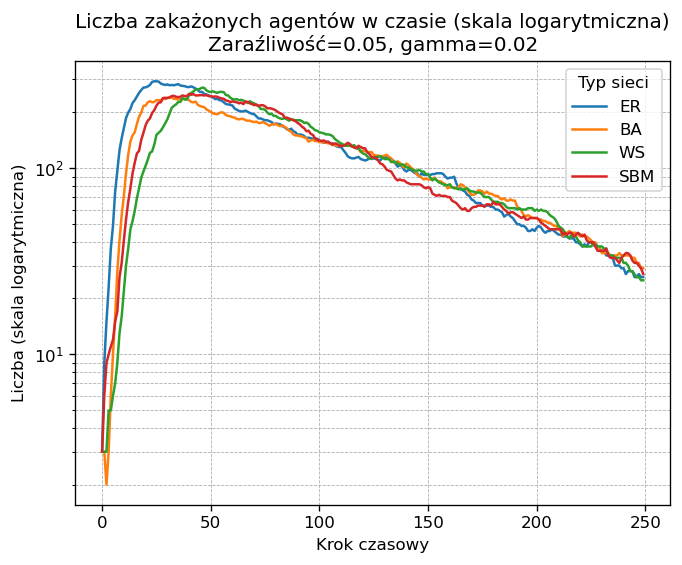

In [20]:
def safe_log_values(x, eps=EPS_LOG):
    return np.asarray(x, dtype=float) + eps

plt.figure(dpi=FIG_DPI)

for nt in NETWORK_TYPES:
    I = SIM_RESULTS[nt]["I"]
    t = np.arange(len(I))
    plt.semilogy(t, safe_log_values(I), label=f"{nt}")

plt.title(f"Liczba zakażonych agentów w czasie (skala logarytmiczna)\nZaraźliwość={VIRUS_INFECTIVITY}, gamma={GAMMA}")
plt.xlabel("Krok czasowy")
plt.ylabel("Liczba (skala logarytmiczna)")
plt.legend(title="Typ sieci")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

Wykres skumulowanej liczby agentow -> sumaryczna ilosc zarazonych agentow, dla kazdego typu sieci

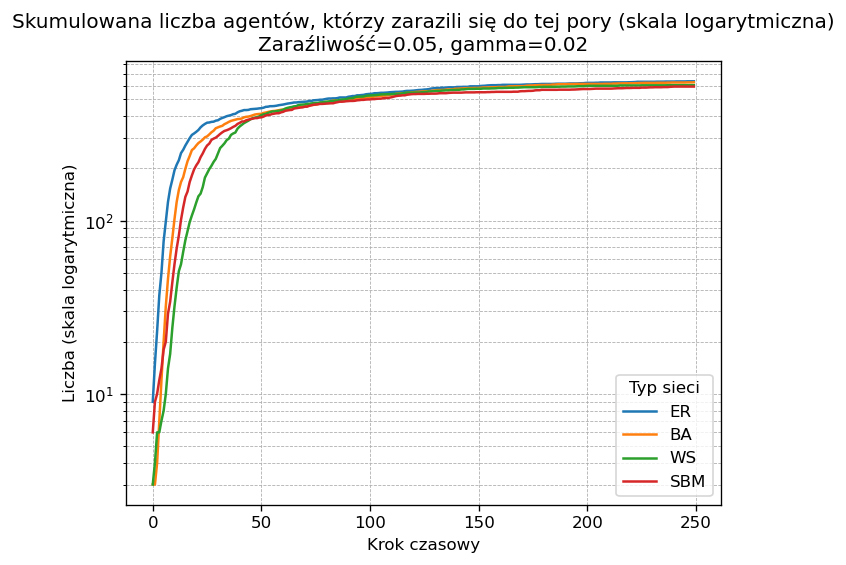

In [21]:
def safe_log_values(x, eps=EPS_LOG):
    return np.asarray(x, dtype=float) + eps

plt.figure(dpi=FIG_DPI)

for nt in NETWORK_TYPES:
    new_inf = SIM_RESULTS[nt]["new_infections"]
    cumulative = np.cumsum(new_inf) + N_INIT_INFECTED  # uwzględniamy zakażonych na starcie
    t = np.arange(len(cumulative))
    plt.semilogy(t, safe_log_values(cumulative), label=f"{nt}")

plt.title(f"Skumulowana liczba agentów, którzy zarazili się do tej pory (skala logarytmiczna)\nZaraźliwość={VIRUS_INFECTIVITY}, gamma={GAMMA}")
plt.xlabel("Krok czasowy")
plt.ylabel("Liczba (skala logarytmiczna)")
plt.legend(title="Typ sieci")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

=== Wnioski ===

Na podstawie wykresów widać, że struktura sieci ma wyraźny wpływ na tempo rozprzestrzeniania się epidemii. W sieciach ER i BA liczba zakażonych rośnie szybciej i osiąga wyższy szczyt niż w sieciach WS i SBM. Skumulowana liczba zakażonych dla wszystkich typów sieci z czasem się stabilizuje, jednak dynamika wzrostu rozni się w zależności od topologii sieci kontaktów.

=== Parametr zarazliwosci COVID oraz GRYPA ===

COVID


=== COVID | Sieć: ER ===
Zapisano GIF: simulation_covid/ER_z0p12.gif

=== COVID | Sieć: BA ===
Zapisano GIF: simulation_covid/BA_z0p12.gif

=== COVID | Sieć: WS ===
Zapisano GIF: simulation_covid/WS_z0p12.gif

=== COVID | Sieć: SBM ===
Zapisano GIF: simulation_covid/SBM_z0p12.gif


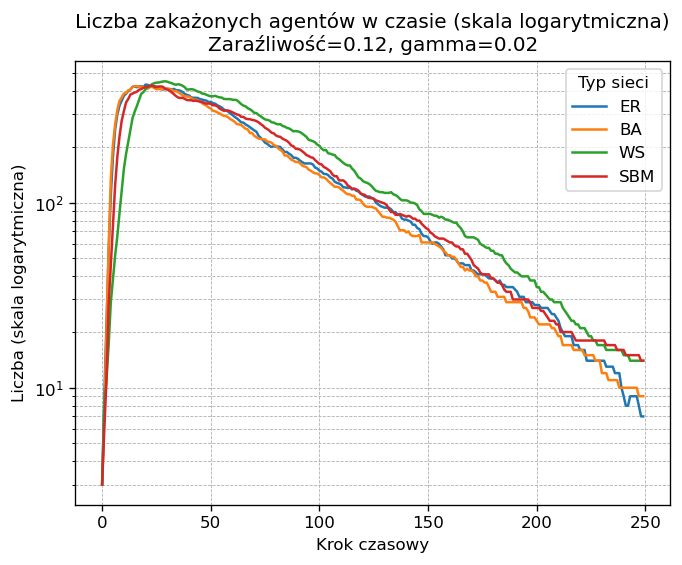

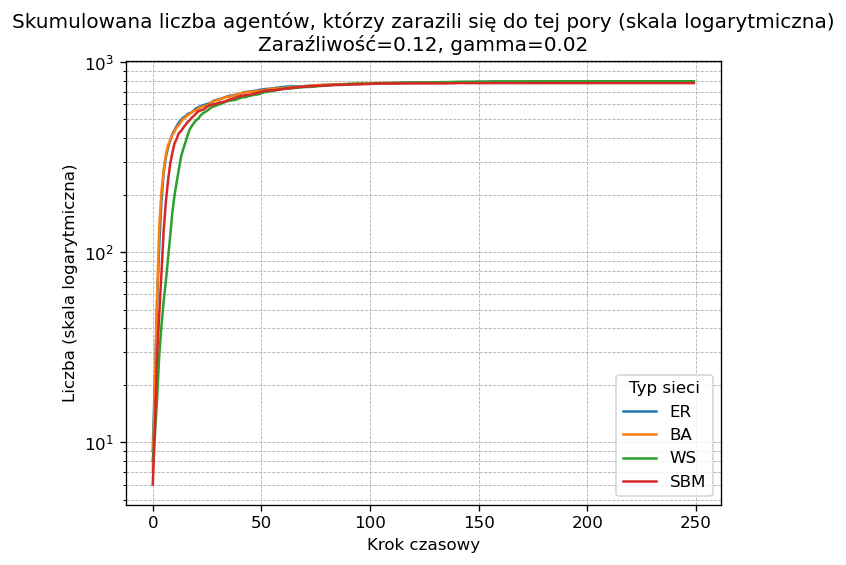

In [22]:
VIRUS_INFECTIVITY_COVID = 0.12
COVID_GIF_DIR = "simulation_covid"

os.makedirs(COVID_GIF_DIR, exist_ok=True)

def safe_log_values(x, eps=EPS_LOG):
    return np.asarray(x, dtype=float) + eps

# === Symulacje + GIF-y (dla każdej sieci osobno)
SIM_RESULTS_COVID = {}

for nt in NETWORK_TYPES:
    print(f"\n=== COVID | Sieć: {nt} ===")

    G_nt = build_network(nt, N_AGENTS, seed=RANDOM_SEED)
    states0 = init_states(N_AGENTS, N_INIT_INFECTED)
    attrs = init_agent_attributes(N_AGENTS, USE_HETEROGENEITY)

    sim = run_simulation(
        G_nt,
        T=T_MAX,
        states_init=states0,
        attrs=attrs,
        virus_infectivity=VIRUS_INFECTIVITY_COVID,
        n_trials=N_INFECTION_TRIALS,
        gamma=GAMMA
    )

    SIM_RESULTS_COVID[nt] = sim

    gif_path = make_gif_for_network(
        G_nt,
        T=T_MAX,
        states_init=states0,
        attrs=attrs,
        network_type=nt,
        virus_infectivity=VIRUS_INFECTIVITY_COVID,
        every=GIF_EVERY,
        fps=GIF_FPS,
        layout_name=GIF_LAYOUT,
        out_dir=COVID_GIF_DIR
    )
    print("Zapisano GIF:", gif_path)

# === Wykres 1: liczba zakażonych w czasie (I(t))
plt.figure(dpi=FIG_DPI)

for nt in NETWORK_TYPES:
    I = SIM_RESULTS_COVID[nt]["I"]
    t = np.arange(len(I))
    plt.semilogy(t, safe_log_values(I), label=f"{nt}")

plt.title(
    "Liczba zakażonych agentów w czasie (skala logarytmiczna)\n"
    f"Zaraźliwość={VIRUS_INFECTIVITY_COVID}, gamma={GAMMA}"
)
plt.xlabel("Krok czasowy")
plt.ylabel("Liczba (skala logarytmiczna)")
plt.legend(title="Typ sieci")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

# === Wykres 2: skumulowana liczba zakażonych do tej pory
plt.figure(dpi=FIG_DPI)

for nt in NETWORK_TYPES:
    new_inf = SIM_RESULTS_COVID[nt]["new_infections"]
    cumulative = np.cumsum(new_inf) + N_INIT_INFECTED
    t = np.arange(len(cumulative))
    plt.semilogy(t, safe_log_values(cumulative), label=f"{nt}")

plt.title(
    "Skumulowana liczba agentów, którzy zarazili się do tej pory (skala logarytmiczna)\n"
    f"Zaraźliwość={VIRUS_INFECTIVITY_COVID}, gamma={GAMMA}"
)
plt.xlabel("Krok czasowy")
plt.ylabel("Liczba (skala logarytmiczna)")
plt.legend(title="Typ sieci")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

GRYPA


=== GRYPA | Sieć: ER ===
Zapisano GIF: simulation_flu/ER_z0p04.gif

=== GRYPA | Sieć: BA ===
Zapisano GIF: simulation_flu/BA_z0p04.gif

=== GRYPA | Sieć: WS ===
Zapisano GIF: simulation_flu/WS_z0p04.gif

=== GRYPA | Sieć: SBM ===
Zapisano GIF: simulation_flu/SBM_z0p04.gif


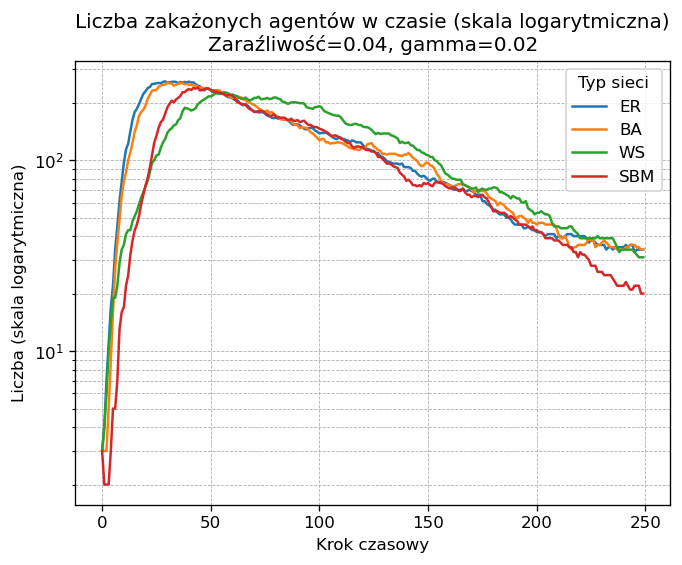

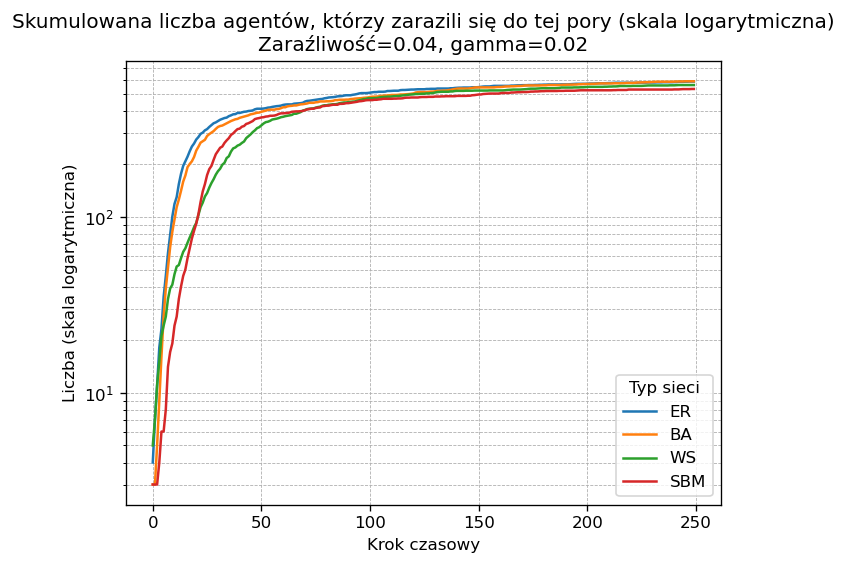

In [23]:
VIRUS_INFECTIVITY_FLU = 0.04
FLU_GIF_DIR = "simulation_flu"

os.makedirs(FLU_GIF_DIR, exist_ok=True)

def safe_log_values(x, eps=EPS_LOG):
    return np.asarray(x, dtype=float) + eps

# === Symulacje + GIF-y (dla każdej sieci osobno)
SIM_RESULTS_FLU = {}

for nt in NETWORK_TYPES:
    print(f"\n=== GRYPA | Sieć: {nt} ===")

    G_nt = build_network(nt, N_AGENTS, seed=RANDOM_SEED)
    states0 = init_states(N_AGENTS, N_INIT_INFECTED)
    attrs = init_agent_attributes(N_AGENTS, USE_HETEROGENEITY)

    sim = run_simulation(
        G_nt,
        T=T_MAX,
        states_init=states0,
        attrs=attrs,
        virus_infectivity=VIRUS_INFECTIVITY_FLU,
        n_trials=N_INFECTION_TRIALS,
        gamma=GAMMA
    )

    SIM_RESULTS_FLU[nt] = sim

    gif_path = make_gif_for_network(
        G_nt,
        T=T_MAX,
        states_init=states0,
        attrs=attrs,
        network_type=nt,
        virus_infectivity=VIRUS_INFECTIVITY_FLU,
        every=GIF_EVERY,
        fps=GIF_FPS,
        layout_name=GIF_LAYOUT,
        out_dir=FLU_GIF_DIR
    )
    print("Zapisano GIF:", gif_path)

# === Wykres 1: liczba zakażonych w czasie (I(t))
plt.figure(dpi=FIG_DPI)

for nt in NETWORK_TYPES:
    I = SIM_RESULTS_FLU[nt]["I"]
    t = np.arange(len(I))
    plt.semilogy(t, safe_log_values(I), label=f"{nt}")

plt.title(
    "Liczba zakażonych agentów w czasie (skala logarytmiczna)\n"
    f"Zaraźliwość={VIRUS_INFECTIVITY_FLU}, gamma={GAMMA}"
)
plt.xlabel("Krok czasowy")
plt.ylabel("Liczba (skala logarytmiczna)")
plt.legend(title="Typ sieci")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

# === Wykres 2: skumulowana liczba zakażonych do tej pory
plt.figure(dpi=FIG_DPI)

for nt in NETWORK_TYPES:
    new_inf = SIM_RESULTS_FLU[nt]["new_infections"]
    cumulative = np.cumsum(new_inf) + N_INIT_INFECTED
    t = np.arange(len(cumulative))
    plt.semilogy(t, safe_log_values(cumulative), label=f"{nt}")

plt.title(
    "Skumulowana liczba agentów, którzy zarazili się do tej pory (skala logarytmiczna)\n"
    f"Zaraźliwość={VIRUS_INFECTIVITY_FLU}, gamma={GAMMA}"
)
plt.xlabel("Krok czasowy")
plt.ylabel("Liczba (skala logarytmiczna)")
plt.legend(title="Typ sieci")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

=== Wnioski === 

Symulacje pokazują, że przy wyższej zaraźliwości odpowiadającej COVID-19 epidemia rozprzestrzenia się znacznie szybciej i prowadzi do większej skumulowanej liczby zakażeń niż w przypadku grypy. Dla grypy przebieg epidemii jest wolniejszy, a wpływ struktury sieci kontaktów społecznych na dynamikę zakażeń jest bardziej widoczny.

=== Mozliwosc ponownego zarazenia agenta ===

In [24]:
VIRUS_INFECTIVITY_REINF = 0.05
OMEGA = 0.01  # R -> S (utrata odporności / ponowna podatność)
REINF_DIR = "simulation_reinfection"

os.makedirs(REINF_DIR, exist_ok=True)

def safe_log_values(x, eps=EPS_LOG):
    return np.asarray(x, dtype=float) + eps

def sirs_step(G, states, attrs, virus_infectivity, n_trials, gamma, omega):
    n = states.size
    new_states = states.copy()

    #  S -> I (chory sąsiad + 3 losowania + próg odporności)
    new_infected = np.zeros(n, dtype=bool)
    for v in range(n):
        if states[v] != SUSC:
            continue

        has_infected_neighbor = False
        for u in G.neighbors(v):
            if states[u] == INF:
                has_infected_neighbor = True
                break
        if not has_infected_neighbor:
            continue

        p = virus_infectivity * attrs.susceptibility[v]
        if p < 0.0: p = 0.0
        if p > 1.0: p = 1.0

        successes = 0
        for _ in range(n_trials):
            if np.random.rand() < p:
                successes += 1

        infection_score = successes / float(n_trials)
        if infection_score > attrs.resistance_threshold[v]:
            new_infected[v] = True

    new_states[new_infected] = INF
    new_infections_count = int(np.sum(new_infected))

    # 2) I -> R (ozdrowienie)
    infected_before = (states == INF)
    if np.any(infected_before):
        recover = (np.random.rand(n) < gamma) & infected_before
        new_states[recover] = REC

    # 3) R -> S (utrata odporności, ponowna podatność)
    recovered_before = (states == REC)
    if np.any(recovered_before):
        lose_immunity = (np.random.rand(n) < omega) & recovered_before
        new_states[lose_immunity] = SUSC

    return new_states, new_infections_count


def run_simulation_sirs(G, T, states_init, attrs, virus_infectivity, n_trials, gamma, omega):
    states = states_init.copy()
    I_hist = []
    new_inf_hist = []

    for _ in range(T):
        I_hist.append(int(np.sum(states == INF)))
        states, new_inf = sirs_step(G, states, attrs, virus_infectivity, n_trials, gamma, omega)
        new_inf_hist.append(int(new_inf))

        if I_hist[-1] == 0 and len(I_hist) > 10:
            break

    return {
        "I": np.array(I_hist, dtype=int),
        "new_infections": np.array(new_inf_hist, dtype=int),
    }

def compute_layout(G, layout_name="spring", seed=RANDOM_SEED):
    if layout_name == "kamada_kawai":
        return nx.kamada_kawai_layout(G)
    return nx.spring_layout(G, seed=seed)

def make_gif_sirs(G, T, states_init, attrs, network_type, virus_infectivity, gamma, omega,
                 every, fps, layout_name, out_dir):
    pos = compute_layout(G, layout_name=layout_name)
    states = states_init.copy()

    frames_states = []
    for t in range(T):
        if t % every == 0:
            frames_states.append(states.copy())

        states, _ = sirs_step(G, states, attrs, virus_infectivity, N_INFECTION_TRIALS, gamma, omega)

        if t > 20 and np.sum(states == INF) == 0:
            break

    color_map = {SUSC: "tab:blue", INF: "tab:red", REC: "tab:green"}
    legend_elements = [
        Patch(facecolor="tab:blue", label="Podatni (S)"),
        Patch(facecolor="tab:red", label="Zakażeni (I)"),
        Patch(facecolor="tab:green", label="Ozdrowiali (R)")
    ]

    fig, ax = plt.subplots(figsize=(7, 6), dpi=FIG_DPI)
    ax.set_axis_off()

    def draw_frame(i):
        ax.clear()
        ax.set_axis_off()

        st = frames_states[i]
        node_colors = [color_map[int(s)] for s in st]

        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=30, ax=ax)
        nx.draw_networkx_edges(G, pos, alpha=0.15, width=0.6, ax=ax)

        s_cnt = int(np.sum(st == SUSC))
        i_cnt = int(np.sum(st == INF))
        r_cnt = int(np.sum(st == REC))

        fig.suptitle(
            f"Epidemia SIRS (ponowne zakażenie)\n"
            f"Sieć: {network_type} | Zaraźliwość: {virus_infectivity} | "
            f"gamma={gamma}, omega={omega} | Klatka {i+1}/{len(frames_states)}",
            fontsize=12
        )
        ax.legend(handles=legend_elements, loc="upper right", frameon=True)
        ax.text(
            0.02, 0.02,
            f"Podatni (S): {s_cnt}\nZakażeni (I): {i_cnt}\nOzdrowiali (R): {r_cnt}",
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="bottom",
            bbox=dict(boxstyle="round", alpha=0.25)
        )

    anim = animation.FuncAnimation(fig, draw_frame, frames=len(frames_states), interval=1000 / fps)

    z_txt = str(virus_infectivity).replace(".", "p")
    o_txt = str(omega).replace(".", "p")
    out_path = os.path.join(out_dir, f"{network_type}_z{z_txt}_o{o_txt}.gif")

    anim.save(out_path, writer="pillow", fps=fps)
    plt.close(fig)
    return out_path

Uruchomienie Symulacji


=== REINFECTION (SIRS) | Sieć: ER ===
Zapisano GIF: simulation_reinfection/ER_z0p05_o0p01.gif

=== REINFECTION (SIRS) | Sieć: BA ===
Zapisano GIF: simulation_reinfection/BA_z0p05_o0p01.gif

=== REINFECTION (SIRS) | Sieć: WS ===
Zapisano GIF: simulation_reinfection/WS_z0p05_o0p01.gif

=== REINFECTION (SIRS) | Sieć: SBM ===
Zapisano GIF: simulation_reinfection/SBM_z0p05_o0p01.gif


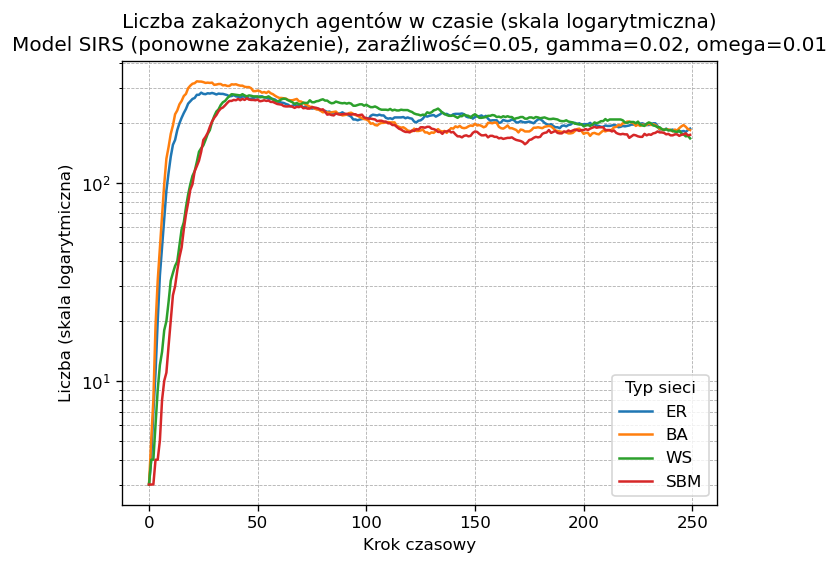

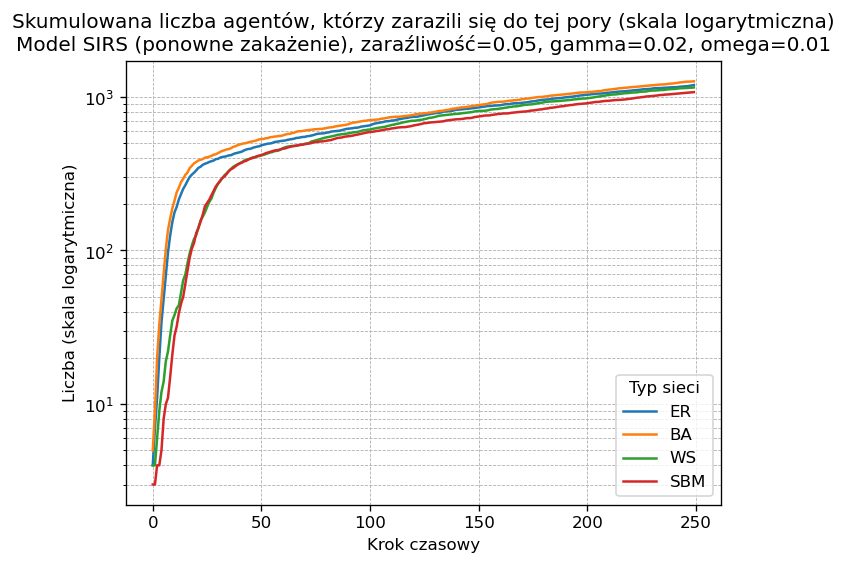

In [26]:
IM_RESULTS_REINF = {}

for nt in NETWORK_TYPES:
    print(f"\n=== REINFECTION (SIRS) | Sieć: {nt} ===")

    G_nt = build_network(nt, N_AGENTS, seed=RANDOM_SEED)
    states0 = init_states(N_AGENTS, N_INIT_INFECTED)
    attrs = init_agent_attributes(N_AGENTS, USE_HETEROGENEITY)

    sim = run_simulation_sirs(
        G_nt,
        T=T_MAX,
        states_init=states0,
        attrs=attrs,
        virus_infectivity=VIRUS_INFECTIVITY_REINF,
        n_trials=N_INFECTION_TRIALS,
        gamma=GAMMA,
        omega=OMEGA
    )
    IM_RESULTS_REINF[nt] = sim

    gif_path = make_gif_sirs(
        G_nt,
        T=T_MAX,
        states_init=states0,
        attrs=attrs,
        network_type=nt,
        virus_infectivity=VIRUS_INFECTIVITY_REINF,
        gamma=GAMMA,
        omega=OMEGA,
        every=GIF_EVERY,
        fps=GIF_FPS,
        layout_name=GIF_LAYOUT,
        out_dir=REINF_DIR
    )
    print("Zapisano GIF:", gif_path)

# WYKRES 1: I(t) - liczba zakażonych w czasie
plt.figure(dpi=FIG_DPI)
for nt in NETWORK_TYPES:
    I = IM_RESULTS_REINF[nt]["I"]
    t = np.arange(len(I))
    plt.semilogy(t, safe_log_values(I), label=f"{nt}")

plt.title(
    "Liczba zakażonych agentów w czasie (skala logarytmiczna)\n"
    f"Model SIRS (ponowne zakażenie), zaraźliwość={VIRUS_INFECTIVITY_REINF}, gamma={GAMMA}, omega={OMEGA}"
)
plt.xlabel("Krok czasowy")
plt.ylabel("Liczba (skala logarytmiczna)")
plt.legend(title="Typ sieci")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

# WYKRES 2: skumulowana liczba zakażonych
plt.figure(dpi=FIG_DPI)
for nt in NETWORK_TYPES:
    new_inf = IM_RESULTS_REINF[nt]["new_infections"]
    cumulative = np.cumsum(new_inf) + N_INIT_INFECTED
    t = np.arange(len(cumulative))
    plt.semilogy(t, safe_log_values(cumulative), label=f"{nt}")

plt.title(
    "Skumulowana liczba agentów, którzy zarazili się do tej pory (skala logarytmiczna)\n"
    f"Model SIRS (ponowne zakażenie), zaraźliwość={VIRUS_INFECTIVITY_REINF}, gamma={GAMMA}, omega={OMEGA}"
)
plt.xlabel("Krok czasowy")
plt.ylabel("Liczba (skala logarytmiczna)")
plt.legend(title="Typ sieci")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

=== Wnioski ===

W modelu z możliwością ponownego zakażenia liczba zakażonych agentów nie maleje w strone 0, ale stabilizuje się na pewnym poziomie, co wskazuje na utrzymywanie się epidemii w czasie. Skumulowana liczba zakażeń rośnie dalej, ponieważ część agentów może chorować wielokrotnie.